In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the path where your model and tokenizer are saved in Drive
model_path = "/content/drive/My Drive/ADL Final Project/final_model"

In [ ]:
# Load the tokenizer and model from Drive
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Load test dataset from Drive
test_csv_path = "/content/drive/My Drive/ADL Final Project/yelp_dataset_test.csv"
test_df = pd.read_csv(test_csv_path)

In [ ]:
# Extract texts and labels
test_texts = test_df['review_text'].tolist()
test_labels = test_df['class_index'].tolist()

# Tokenize the test texts
test_encodings = tokenizer(test_texts, truncation = True, padding = True, max_length = 512)

# Create a PyTorch Dataset for the test data
class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Convert each item to torch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = YelpDataset(test_encodings, test_labels)

In [ ]:
# Initialize Trainer
trainer = Trainer(model = model)

In [ ]:
# Run evaluation on the test dataset
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis = 1)
labels = predictions.label_ids

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neel-1999 (neel-1999-humber-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Compute evaluation metrics
acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'weighted', zero_division = 0)
cm = confusion_matrix(labels, preds)

In [ ]:
# Print out the metrics
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.9546
Precision: 0.9545
Recall: 0.9546
F1 Score: 0.9545
Confusion Matrix:
[[9676  295   29]
 [ 344 9291  365]
 [  29  301 9670]]


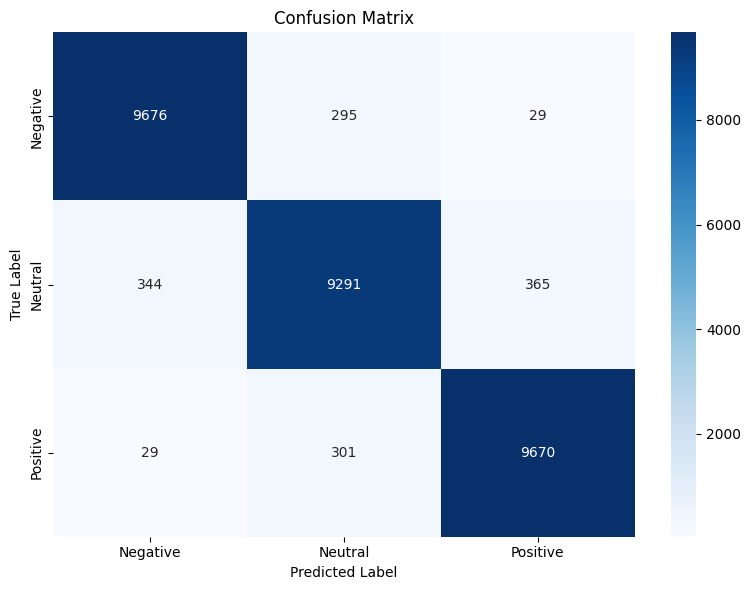

In [ ]:
class_names = ['Negative', 'Neutral', 'Positive']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()